# PRA

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import seaborn as sns
import pandas as pd
from qsim.helpers import all_simulations
from qsim.logical_gate.lidle import LIdleGatePRA
from qsim.logical_gate.phenomenological import *
from qsim.utils.logical_fit import FitAllAtOnce
from qsim.utils.quantum_guidelines import *
from qsim.utils.utils import generate_ax_params, generate_plot_params

generate_plot_params()

marker_list = ["o", "s", "v", "^", "<", ">", "D", "X", "P"]
sns.set(rc={"figure.facecolor": "white"})
props = global_setup(columns="twocolumn", paper="a4paper", fontsize=11)

%matplotlib inline

Setup methods loaded


In [4]:
res_dict = {}
for gate in [LIdleGatePRA]:
    db_res = all_simulations(gate)
    for single_res in db_res:
        if single_res["distance"] == single_res["num_rounds"]:
            outcome = single_res["state"]["outcome"]["Z"]
            num_trajectories = single_res["state"]["num_trajectories"]["Z"]

            res_dict[(single_res["p"], single_res["distance"])] = (
                outcome,
                num_trajectories,
            )

In [6]:
d_l = []
p_l = []
for k, v in res_dict.items():
    p, d = k
    if d not in d_l:
        d_l.append(d)
    if p not in p_l:
        p_l.append(p)

FitAllAtOnce 
$p_L = ad(p/p_{th})^{c(d+1)}$, 
$a=0.071, p_{th}=0.00805, c=0.252$



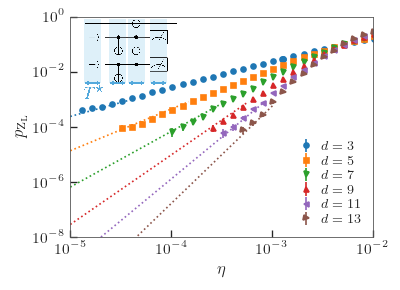

In [23]:
from qsim.utils.quantum_guidelines import *
from qsim.utils.utils import PRA_p_to_k1
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import matplotlib.pyplot as plt

fig = plot_setup(1 / 1.40)
ax = fig.add_subplot()

fit = FitAllAtOnce(
    max_p_L=4e-3,
    rel_tol=3e-1,
)
for (p, d), (fid, N) in res_dict.items():
    k1 = PRA_p_to_k1(p=p, k2=1)
    fit.update(k1, d, 1 - fid, N)


to_remove = []
for p, d in fit.data.keys():
    v = fit.data[(p, d)]
    if error_bar(N=v["num_trajectories"], p=v["pl"]) > 0.40 * v["pl"]:
        to_remove.append((p, d))
for k in to_remove:
    fit.data.pop(k)

ax = fit.plot(
    ax=ax,
    marker_list=["o", "s", "v", "^", "<", ">", "D", "X", "P"],
)

print(fit.gen_title())
plt.xlim(1e-5, 1e-2)
plt.ylim(1e-8, 1)
ax.set_xscale("log")
ax.set_xlabel("$\\kappa_1 / \\kappa_2$")


from matplotlib.offsetbox import OffsetImage, AnnotationBbox
arr_img = plt.imread("circuit_PRA.png")
im = OffsetImage(arr_img, zoom=.035)
im.image.axes = ax

ab = AnnotationBbox(
    im,
    xy=(0, 1),
    xycoords='axes fraction', 
    box_alignment=(-0.15, 1.02),
    frameon=False
)
ax.add_artist(ab)

# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title("")
plt.xlabel("$\\eta$")
plt.ylabel("$p_{\mathrm{Z_L}}$")
ax.legend(handletextpad=0.08, labelspacing=0.2, frameon=False)
plt.tight_layout(pad=0.3)


# generate_ax_params(ax)
plt.savefig("PRA_fitted.pdf", dpi=1000)

In [14]:
import matplotlib.pylab as pl
import numpy as np

p_x_values = np.load("px.npy", allow_pickle=True).item()
p_x_values = dict(filter(lambda x: x[1] >= 0.0, p_x_values.items()))

In [9]:
k1_labels = {
    0.001: r"$10^{-3}$",
    0.01: r"$10^{-2}$",
    0.03: r"$3 \times 10^{-2}$",
    0.1: r"$10^{-1}$",
}

In [10]:
delta = 10 ** (-3)

def pX_CX(k1, x):
    return (5.58 * np.sqrt(k1) + 1.68 * k1) * np.exp(-2 * x)


def ptodelta(p):
    return 4 * np.pi * p**2


def deltatop(delta):
    return 1 / 2 / np.sqrt(np.pi) * np.sqrt(delta)


def p_func(d, nbar, delta):
    A = 0.09295
    pth = 0.01763
    p = deltatop(delta)
    T = 1 / 2 / nbar / np.sqrt(np.pi) * np.sqrt(delta)

    # p_ZL = A * (p / pth) ** ((d + 1) / 2)
    p_ZL = A * (p / pth) ** ((d + 1) / 2) / d
    # p_XL = 2 * d**2 * pX_idle(delta,nbar,T) + 2 * d * (d-1) * pX_CX(delta,nbar)
    # p_XL = 2 * d * (d - 1) * pX_CX(delta, nbar)
    p_XL = 2 * (d - 1) * pX_CX(delta, nbar)

    return p_XL, p_ZL

In [11]:
def optimize(p_target, delta):
    if deltatop(delta) > 0.01791:
        return "Error, delta is above threshold."

    p_XL = 0.5
    p_ZL = 0.5
    d = 3
    nbar = 2

    while p_XL + p_ZL > p_target:
        if p_XL > p_target / 2:
            nbar += 2
        p_XL, p_ZL = p_func(d, nbar, delta)
        if p_ZL > p_target / 2:
            d += 2
        p_XL, p_ZL = p_func(d, nbar, delta)

    return d, round(nbar, 3), p_XL, p_ZL

In [12]:
pth = 0.01791
deltath = ptodelta(pth)

delta_list = list(
    np.logspace(np.log10(ptodelta(0.001)), np.log10(deltath / 1.2), 25)
)
print(delta_list)
p_list = [deltatop(delta) for delta in delta_list]
print(p_list)

[1.2566370614359185e-05, 1.5861172106331776e-05, 2.001984409875741e-05, 2.5268886501682615e-05, 3.189418568322164e-05, 4.0256585122105955e-05, 5.081153856033066e-05, 6.413391605464887e-05, 8.09493139756243e-05, 0.00010217357423707813, 0.0001289626651502355, 0.0001627756406373846, 0.00020545410684591912, 0.0002593225242706228, 0.0003273148082871895, 0.0004131341233292797, 0.0005214545738159704, 0.0006581757768212031, 0.0008307441816534447, 0.0010485586368495761, 0.0013234822935786746, 0.001670488726008703, 0.0021084774592462626, 0.0026613033221550837, 0.003359075688219852]
[0.0010000000000000005, 0.0011234731736792809, 0.0012621919719769954, 0.0014180388205495044, 0.0015931285741231753, 0.0017898372152493106, 0.0020108340965854284, 0.00225911816423334, 0.002538058653687741, 0.0028514408106427276, 0.0032035172570914054, 0.0035990656997608246, 0.004043453763990535, 0.004542711832855878, 0.0051036148799690146, 0.005733774406435589, 0.006441741729559223, 0.007237124024930158, 0.008130714696

In [15]:
lines = dict()
pL_labels = {
    10 ** -(5): r"$10^{-5}$",
    10 ** -(7): r"$10^{-7}$",
    10 ** -(10): r"$10^{-10}$",
}

marker_p = {
    10 ** -(5): "v",
    10 ** -(7): "o",
    10 ** -(10): "s",
}

colors = pl.cm.jet(np.linspace(0, 0.3, 3))

In [16]:
for p_target in [1e-5, 1e-7, 1e-10]:
    X = []
    Y = []
    label = []
    pXL_l = []
    pZL_l = []
    for p in p_list:
        delta = ptodelta(p)
        X.append(delta)
        tup = optimize(p_target, delta)
        Y.append(tup[0])
        label.append(tup[1])
        pXL_l.append(tup[2])
        pZL_l.append(tup[3])
        # print(tup[2]/tup[3])
    lines[p_target] = X, Y, label, pXL_l, pZL_l

In [17]:
results_PT = np.load("PT_results.npy", allow_pickle=True).item()
timing = np.load("timing.npy", allow_pickle=True).item()

lines2 = dict()
for delta in [0.0001, 0.001, 0.01, 0.1]:
    lines2[delta] = [], []

for key in sorted(timing):
    nbar, N, delta, T = key
    lines2[delta][0].append(nbar)
    Chi2Error = results_PT[key][1]
    thresh = 1e-10
    C2E = Chi2Error

    RC2E = abs(np.real(C2E))
    indices = RC2E < thresh
    RC2E[indices] = 0
    IC2E = abs(np.imag(C2E))
    indices = IC2E < thresh
    IC2E[indices] = 0

    lines2[delta][1].append(
        1 - RC2E[0, 0] - RC2E[3, 3] - RC2E[12, 12] - RC2E[15, 15]
    )

In [18]:
def ptopth(p):
    return p / pth


def pthtop(pth):
    return p * pth


def ptodelta(p):
    return 4 * np.pi * p**2


def deltatop(delta):
    return 1 / 2 / np.sqrt(np.pi) * np.sqrt(delta)


def optimal_gate_time(nbar: int, k1: float, k2: float, **kwargs) -> float:
    # cf PRA
    return 1 / 2 / nbar / np.sqrt(np.pi) / np.sqrt(k1 * k2)

In [19]:
from qsim.logical_gate.process_results import PRA
method = PRA()
method.load_df()

dfx
dffx
dfz
dffz
dfo


[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 10]
[13.26291192 11.80527692 10.5078405   9.35299636  8.32507315  7.41012189
  6.59572659  5.87083586  5.22561285  4.65130185  4.1401094   2.76382394
  2.46007115  2.18970173  1.94904674  1.73484048  1.54417615  1.37446642
  1.22340831  1.08895196  0.96927277  0.8627467   0.76792817  0.68353049
  0.4867267 ]
[8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 12, 12]
[9.94718394 8.85395769 7.88088038 7.01474727 4.99504389 4.44607313
 3.95743596 3.52250151 3.13536771 2.79078111 2.48406564 2.21105915
 1.96805692 1.75176138 1.55923739 1.38787238 1.23534092 1.09957314
 0.97872665 0.87116157 0.77541822 0.69019736 0.51195211 0.45568699
 0.40560559]
[12, 12, 12, 12, 12, 12, 12, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 16, 16]
[6.63145596 5.90263846 5.25392025 4.67649818 4.16253658 3.70506094
 3.2978633  2.51607251 2.23954837 1.99341508 1.7743326  1.57932797
 1.4

/var/folders/3s/nd608nl93j95yq_q9rfr02hc00m8zh/T/ipykernel_38807/2880280299.py:274: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.0)


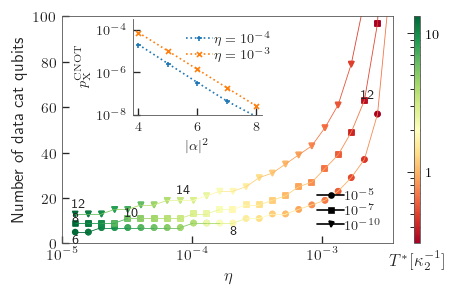

In [22]:
from matplotlib.collections import LineCollection
from matplotlib.colors import LogNorm
from qsim.utils.quantum_guidelines import *

color = "RdYlGn"

fig = plot_setup(aspect_ratio=1/1.7, width_ratio=1.2)
ax = fig.add_subplot()

ymin, ymax = 0, 100
col = 0

text_size = 8

X_global, Y_global, gate_time_global = [], [], []
for p_target in [10 ** -(5), 10 ** (-7), 10 ** (-10)]:
    X, Y, label, pXL_l, pZL_l = lines[p_target]
    X_global.append(X)
    Y_global.append(Y)
    gate_time_l = [
        optimal_gate_time(
            nbar=nbar,
            k1=k1,
            k2=1,
        )
        for (k1, nbar) in zip(X, label)
    ]
    gate_time_global.append(gate_time_l)

points = np.array([X_global, Y_global]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
gate_time_global = np.array(gate_time_global)
# Create a continuous norm to map from data points to colors
# norm = plt.Normalize(gate_time_l.min(), gate_time_l.max())
norm = LogNorm(gate_time_global.min(), gate_time_global.max())

for i, p_target in enumerate([10 ** -(5), 10 ** (-7), 10 ** (-10)]):
    X, Y, label, pXL_l, pZL_l = lines[p_target]
    print(label)
    gate_time_l = [
        optimal_gate_time(
            nbar=nbar,
            k1=k1,
            k2=1,
        )
        for (k1, nbar) in zip(X, label)
    ]

    points = np.array([X, Y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=color, norm=norm, linewidths=0.5)

    gate_time_l = np.array(gate_time_l)
    print(gate_time_l)

    points = np.array([X, Y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)


    # Set the values used for colormapping
    lc.set_array(gate_time_l)
    # lc.set_linewidth(2)
    line = ax.add_collection(lc)
    colors = [norm(val) for val in lc.get_array() for _ in (0, 1)][2:]

    x = [i[0] for j in segments for i in j]
    y = [i[1] for j in segments for i in j]
    ax.scatter(
        x,
        y,
        c=colors,
        marker=marker_list[i],
        # cmap="viridis",
        cmap=color,
    )

    col += 1
    i = 1
    z0 = 0
    for x, y, z in zip(X, Y, label):
        i += 1
        if i % 2 == 0:
            if z >= z0 + 2:
                if y < ymax:
                    r = 1
                    if p_target == 10 ** (-5):
                        plt.text(
                            0.95 * x,
                            y - r - 4,
                            f'{z}',
                            fontsize=text_size,
                        )
                    elif p_target == 10 ** (-10):
                        plt.text(
                            0.95 * x,
                            y + r + 2,
                            f'{z}',
                            fontsize=text_size,
                        )
                    else:
                        if y < 81:
                            plt.text(
                                0.95 * x,
                                y + r,
                                f'{z}',
                                fontsize=text_size,
                            )
                        else:
                            plt.text(
                                0.95 * x,
                                y - r - 5,
                                f'{z}',
                                fontsize=text_size,
                            )
                z0 = z
ticks_list = [0.5] + [i for i in range(1, 6)] + [10]
ticks_list = [1, 10]
cbar = fig.colorbar(
    line,
    ax=ax,
    location="right",
    shrink=1,
    aspect = 20/0.6,
    cmap=plt.cm.get_cmap(color),
    ticks=ticks_list
    # ticks=[0.1, 1, 10]
)
cbar.ax.tick_params(labelsize=text_size)
# cbar.ax.set_yticklabels(['0.1', '1', '10'])
cbar.ax.set_yticklabels([f'${i}$' for i in ticks_list])

cbar.ax.tick_params(which='minor', size=6, width=0.5, colors='black')
cbar.ax.tick_params(which='major', size=8, width=0.5, colors='black')

for i, p_target in enumerate([10 ** -(5), 10 ** (-7), 10 ** (-10)]):
    ax.plot(
        [],
        [],
        marker_list[i] + '-',
        color="black",
        label=pL_labels[p_target],
    )



cbar.ax.set_xlabel("$ T^* [\\kappa_2^{-1}] $")
ax.set_xlabel(
    "$\\eta$",
)  # size=22)
ax.set_ylabel(
    r"Number of data cat qubits",
)  # size=22)

ax.set_xscale("log")
ax.set_ylim(0, 100)
ax.set_xlim(1e-5, 3.5e-3)
ax.legend(
    handletextpad=0.08,
    labelspacing=0.2,
    frameon=False,
    # loc='lower right'
    loc='lower right',
)

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.26, 0.62, 0.28, 0.35]
ax2 = fig.add_axes([left, bottom, width, height])
rect = ax2.patch
rect.set_alpha(0)

k1_labels = [
    "$\\eta = 10^{-4}$",
    "$\\eta = 10^{-3}$",
]

for k1, marker, label in zip([1e-4, 1e-3], ['+:', 'x:'], k1_labels):
    dfxp = method.dfx[
        (method.dfx['k1'] == k1)
        & (method.dfx['nbar'] < 9)
    ].sort_values('nbar')
    # for i, k1 in enumerate(sorted(list(set(k1_fit_l)))):
    ax2.plot(
        dfxp['nbar'].to_numpy(),
        dfxp['pX'].to_numpy(),
        marker,
        label=label
    )
ax2.set_prop_cycle(None)
ax2.set_ylim(1e-8, 3e-4)

ax2.legend(
    handletextpad=0.08,
    labelspacing=0.2,
    frameon=False,
    bbox_to_anchor=(1.15, 1),
    loc="upper right",
)
ax2.set_yscale("log")
ax2.set_xlabel("$|\\alpha|^2$", fontsize=8)
ax2.set_ylabel("$p_\mathrm{X}^{\mathrm{CNOT}}$", fontsize=8)
ax2.tick_params(axis="both", which="major", labelsize=8)
ax2.tick_params(axis="both", which="minor", labelsize=8)


ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


plt.tight_layout(pad=0.0)
# generate_ax_params(ax)
plt.savefig("PRA_overhead.pdf")

plt.show()